In [65]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [66]:
cd gdrive/My Drive/Toxic_Comment_Classification/

[Errno 2] No such file or directory: 'gdrive/My Drive/Toxic_Comment_Classification/'
/content/gdrive/My Drive/Toxic_Comment_Classification


In [67]:
ls

 4thkernel_submission.csv              Improved_LSTM_Reimplement.ipynb
 bi_train_matrix.npy                  'Modeling - 4th Kernel.ipynb'
 cleanining_feature_extraction.ipynb  ' README.md'
 data/                                 tfidf.npy
 Data_Mining_Group_Work.ipynb          uni_tfidf_matrix.npy
 glove_matrix.npy                      Updated_TFIDF.ipynb


In [0]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [0]:
path = 'data/'
EMBEDDING_FILE='data/glove.6B.50d.txt'
TRAIN_DATA_FILE='data/train.csv'
TEST_DATA_FILE='data/test.csv'
CLEAN_TRAIN_FILE='data/clean_nltk2.csv'

In [0]:
embed_size = 50
max_features = 20000
maxlen = 100

## Load Data

In [0]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

In [0]:
clean_train = pd.read_csv(CLEAN_TRAIN_FILE, header=None, index_col=0)

In [73]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [74]:
train.shape

(159571, 8)

In [75]:
clean_train.columns = ['clean_comment_text']
clean_train.head()

,clean_comment_text
0,
0,ExplanationWhy edit make username Hardcore Met...
1,D'aww ! He match background colour I'm seeming...
2,"Hey man , I'm really try edit war . It's guy c..."
3,""" MoreI cannot make real suggestions improveme..."
4,"You , sir , hero . Any chance remember page th..."


In [76]:
clean_train.shape

(312735, 1)

In [0]:
train['clean_comment_text'] = clean_train['clean_comment_text'][:159571]

In [78]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,ExplanationWhy edit make username Hardcore Met...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,D'aww ! He match background colour I'm seeming...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"Hey man , I'm really try edit war . It's guy c..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,""" MoreI cannot make real suggestions improveme..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"You , sir , hero . Any chance remember page th..."


In [0]:
test['clean_comment_text'] = clean_train['clean_comment_text'][159571:]

In [80]:
test.head()

,id,comment_text,clean_comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,Yo bitch Ja Rule succesful you will ever whats...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"= = From RfC = = The title fine , IMO ."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",""" = = Sources = = * Zawe Ashton Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the in...",": If look back source , information I update c..."
4,00017695ad8997eb,I don't anonymously edit articles at all.,I do not anonymously edit article .


## Undersampling

In [0]:
count_toxic_0, count_toxic_1 = train['toxic'].value_counts()

In [0]:
toxic_0 = train[train['toxic'] == 0]
toxic_1 = train[train['toxic'] == 1]

In [0]:
toxic_0_under = toxic_0.sample(count_toxic_1)
train_under = pd.concat([toxic_0_under, toxic_1], axis=0)

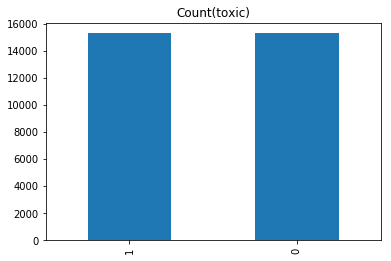

In [84]:
train_under.toxic.value_counts().plot(kind='bar', title='Count(toxic)')

In [85]:
train_under.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment_text
138192,e38b03ba57e3926b,(I wanted to counter the lie in that discussio...,0,0,0,0,0,0,( I want counter lie discussion one support ed...
94367,fc5b854b27cf2c57,Why have I been blocked? I have not been here ...,0,0,0,0,0,0,Why I block ? I past IP address ? I request un...
24718,415656c3d5b9e660,"""\n A third-party, totally uninvolved admin: m...",0,0,0,0,0,0,""" A third-party , totally uninvolved admin : ...."
36651,61e966a24ea16f6d,"Yes, that is your opinion that you share with ...",0,0,0,0,0,0,"Yes , opinion share Tony Sideaway . The folks ..."
142042,f7e055aa620fa154,I don't see how its POV. They're accusations ...,0,0,0,0,0,0,I do not see POV . They're accusations make fe...


### Fill NA

In [0]:
list_sentences_train = train["clean_comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["clean_comment_text"].fillna("_na_").values

### Tokenize

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [117]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


(0.020940498, 0.6441043)

### Embedding and Build model

In [0]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [119]:
print(embedding_matrix.shape)

(20000, 50)


In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.fit(X_t, y, batch_size=32, epochs=6, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/6
143613/143613 [==============================] - 815s 6ms/step - loss: 0.0596 - acc: 0.9794 - val_loss: 0.0489 - val_acc: 0.9818
Epoch 2/6
143613/143613 [==============================] - 787s 5ms/step - loss: 0.0448 - acc: 0.9829 - val_loss: 0.0470 - val_acc: 0.9824
Epoch 3/6
143613/143613 [==============================] - 806s 6ms/step - loss: 0.0406 - acc: 0.9841 - val_loss: 0.0454 - val_acc: 0.9830
Epoch 4/6
143613/143613 [==============================] - 801s 6ms/step - loss: 0.0372 - acc: 0.9851 - val_loss: 0.0463 - val_acc: 0.9827
Epoch 5/6
 85952/143613 [================>.............] - ETA: 5:14 - loss: 0.0341 - acc: 0.9861

### 加载word2vec矩阵

In [87]:
word2vec_matrix = np.load('data/word2vec.npy')
print(word2vec_matrix.shape)/Users/suhang/panopticapi

(144, 100)


In [0]:
embed_size_2 = 100
max_features_2 = 144
maxlen_2 = 100

In [0]:
tokenizer = Tokenizer(num_words=max_features_2)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen_2)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen_2)

In [0]:
inp_2 = Input(shape=(maxlen_2,))
x_2 = Embedding(max_features_2, embed_size_2, weights=[word2vec_matrix])(inp_2)
x_2 = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x_2)
x_2 = GlobalMaxPool1D()(x_2)
x_2 = Dense(50, activation="relu")(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Dense(6, activation="sigmoid")(x_2)
model_2 = Model(inputs=inp_2, outputs=x_2)
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
model_2.fit(X_t, y, batch_size=200, epochs=6, validation_split=0.1)

Train on 27529 samples, validate on 3059 samples
Epoch 1/6
27529/27529 [==============================] - 106s 4ms/step - loss: 0.2972 - acc: 0.8769 - val_loss: 0.4076 - val_acc: 0.8166
Epoch 2/6
27529/27529 [==============================] - 106s 4ms/step - loss: 0.2226 - acc: 0.9108 - val_loss: 0.3851 - val_acc: 0.8241
Epoch 3/6
27529/27529 [==============================] - 107s 4ms/step - loss: 0.2124 - acc: 0.9151 - val_loss: 0.3906 - val_acc: 0.8239
Epoch 4/6
27529/27529 [==============================] - 106s 4ms/step - loss: 0.2075 - acc: 0.9168 - val_loss: 0.3878 - val_acc: 0.8251
Epoch 5/6
27529/27529 [==============================] - 106s 4ms/step - loss: 0.2045 - acc: 0.9171 - val_loss: 0.3655 - val_acc: 0.8342
Epoch 6/6
27529/27529 [==============================] - 106s 4ms/step - loss: 0.2016 - acc: 0.9185 - val_loss: 0.3569 - val_acc: 0.8388


In [109]:
y_test = model_2.predict([X_te], batch_size=1024, verbose=1)
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('data/submission_word2vec_cleanc_us.csv', index=False)

153164/153164 [==============================] - 139s 909us/step
